In [ ]:
# %%

import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, PreTrainedModel
from transformers.models.llama import LlamaModel
from transformers.models.gpt2 import GPT2Model
from enum import Enum
from types import SimpleNamespace
from typing import Union
from collections import defaultdict

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# %%

class DatasetTypes(Enum):
    WIKI = ("wikitext", "wikitext-2-raw-v1")
    INTERNET = ("allenai/c4", "en")
    CODE = "bigcode/starcoderdata"
    ASSISTANT = "HuggingFaceH4/ultrachat_200k"


class ModelTypes(Enum):
    GPT2 = "gpt2"
    LLAMA = "meta-llama/Meta-Llama-3.1-8B"
    GEMMA = "google/gemma-2-9b-it"
    TINY_LLAMA = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"


def get_dataset(dataset_type: DatasetTypes):
    if dataset_type == DatasetTypes.WIKI or dataset_type == DatasetTypes.INTERNET:
        return load_dataset(
            dataset_type.value[0], dataset_type.value[1], streaming=True
        )
    return load_dataset(dataset_type.value, streaming=True)


def get_tokenizer_model(model_type: ModelTypes):
    model_name = model_type.value
    return AutoTokenizer.from_pretrained(
        model_name
    ), AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)


def get_model_config(
    model_type: ModelTypes, model: Union[LlamaModel, GPT2Model, PreTrainedModel]
) -> SimpleNamespace:
    if model_type == ModelTypes.GPT2:
        return SimpleNamespace(n_layer=model.config.n_layer, n_head=model.config.n_head)
    return SimpleNamespace(
        n_layer=model.config.num_hidden_layers,
        n_head=model.config.num_attention_heads,
        seq_len=model.config.max_position_embeddings,
    )

In [ ]:
# %%

dataset = get_dataset(DatasetTypes.INTERNET)

In [ ]:
# %%

model_type = ModelTypes.TINY_LLAMA
tokenizer, model = get_tokenizer_model(model_type)
config = get_model_config(model_type, model)
config

namespace(n_layer=22, n_head=32, seq_len=2048)

In [ ]:
# %%

num_of_samples = 30 

In [ ]:
# %%

stream = iter(dataset["train"])

In [ ]:
# %%

seq_len = config.seq_len
cumsum_metrics = {
    "best": torch.zeros((config.n_layer, config.n_head, seq_len)),
    "avg": torch.zeros((config.n_layer, config.n_head, seq_len)),
    "worst": torch.ones((config.n_layer, config.n_head, seq_len)),
}
layer_cumsum_metrics = {
    "best": torch.zeros((config.n_layer, config.n_head * seq_len)),
    "avg": torch.zeros((config.n_layer, config.n_head * seq_len)),
    "worst": torch.ones((config.n_layer, config.n_head * seq_len)),
}

In [ ]:
# %%

num_of_samples = 100

In [ ]:
# %%

stream = iter(dataset["train"])

In [ ]:
# %%

seq_len = config.seq_len
cumsum_metrics = {
    "best": torch.zeros((config.n_layer, config.n_head, seq_len)),
    "avg": torch.zeros((config.n_layer, config.n_head, seq_len)),
    "worst": torch.ones((config.n_layer, config.n_head, seq_len)),
}
layer_cumsum_metrics = {
    "best": torch.zeros((config.n_layer, config.n_head * seq_len)),
    "avg": torch.zeros((config.n_layer, config.n_head * seq_len)),
    "worst": torch.ones((config.n_layer, config.n_head * seq_len)),
}

In [ ]:
# %%

for i in range(num_of_samples):
    cur_seq_len = 0

    while cur_seq_len <= seq_len:
        input_text = next(stream)["text"]
        inputs = tokenizer(input_text, return_tensors="pt")
        cur_seq_len = inputs.input_ids.shape[1]

    # cap length of input to min sequence length tokens
    inputs_sliced = {
        "input_ids": inputs.input_ids[:, :seq_len],
        "attention_mask": inputs.attention_mask[:, :seq_len],
    }

    metrics = defaultdict(
        lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0.0)))
    )

    # Run the model
    with torch.no_grad():
        outputs = model(**inputs_sliced)

    attentions = torch.cat(outputs.attentions, dim=0)
    att_wei = attentions[:, :, -1, :]  # get query projection
    layer_att_wei = torch.reshape(att_wei, (config.n_layer, config.n_head * seq_len))

    att_wei = torch.sort(att_wei, dim=-1, descending=True).values
    layer_att_wei = torch.sort(layer_att_wei, dim=-1, descending=True).values

    cum_prob = att_wei.cumsum(dim=-1)
    cum_layer_prob = layer_att_wei.cumsum(dim=-1)

    cumsum_metrics["avg"] += cum_prob
    cumsum_metrics["best"] = torch.max(cumsum_metrics["best"], cum_prob)
    cumsum_metrics["worst"] = torch.min(cumsum_metrics["worst"], cum_prob)

    layer_cumsum_metrics["avg"] += cum_layer_prob
    layer_cumsum_metrics["best"] = torch.max(
        layer_cumsum_metrics["best"], cum_layer_prob
    )
    layer_cumsum_metrics["worst"] = torch.min(
        layer_cumsum_metrics["worst"], cum_layer_prob
    )

In [ ]:
# %%

cumsum_metrics["avg"] = cumsum_metrics["avg"] / num_of_samples
layer_cumsum_metrics["avg"] = (
    layer_cumsum_metrics["avg"] / num_of_samples / config.n_head
)

In [ ]:
# %%

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# %%

def plot_cum_layer_prob(layer_metrics):
    n_layers, k_len = layer_metrics.shape

    # Create a color map for the
    colors = plt.cm.rainbow(np.linspace(0, 1, n_layers))

    plt.figure(figsize=(15, 8))
    for layer in range(n_layers):
        # Create a new figure for each layer

        # Plot the line for thislayer
        plt.plot(
            range(k_len),
            layer_metrics[layer, :],
            color=colors[layer],
            label=f"Layer {layer}",
        )

    plt.title(f"Cumulative probability for all layers", fontsize=16)
    plt.xlabel("Number of keys processed", fontsize=12)
    plt.ylabel("Cumulative probability", fontsize=12)
    plt.ylim(0, 1)  # Assuming cumulative values are between 0 and 1
    plt.minorticks_on()

    plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

    # Add a legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

    plt.tight_layout()
    plt.show()

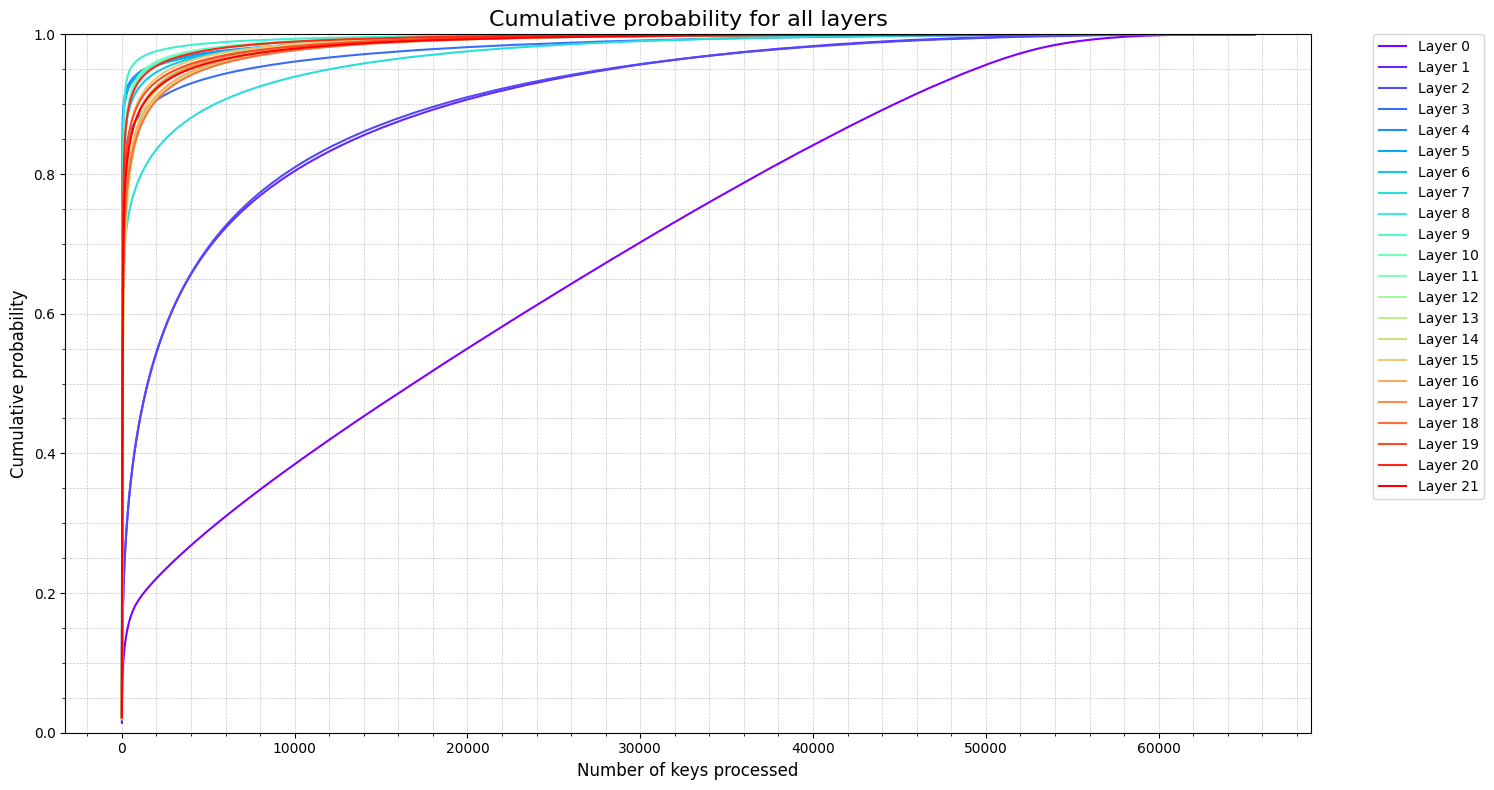

In [ ]:
# %%

plot_cum_layer_prob(layer_cumsum_metrics["avg"].numpy())

In [ ]:
# %%

def plot_cum_prob_per_layer(cumsum_metrics):
    num_layers, num_heads, seq_length = cumsum_metrics.shape

    # Create a color map for the heads
    colors = plt.cm.rainbow(np.linspace(0, 1, num_heads))

    for layer in range(num_layers):
        # Create a new figure for each layer
        plt.figure(figsize=(15, 8))

        for head in range(num_heads):
            # Get data for the current head
            head_data = cumsum_metrics[layer, head, :]

            # Plot the line for this head
            plt.plot(
                range(seq_length), head_data, color=colors[head], label=f"Head {head}"
            )

        plt.title(f"Cumulative probability for Layer {layer}", fontsize=16)
        plt.xlabel("Number of keys processed", fontsize=12)
        plt.ylabel("Cumulative probability", fontsize=12)
        plt.ylim(0, 1)  # Assuming cumulative values are between 0 and 1

        # Add a legend
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)

        plt.tight_layout()
        plt.show()

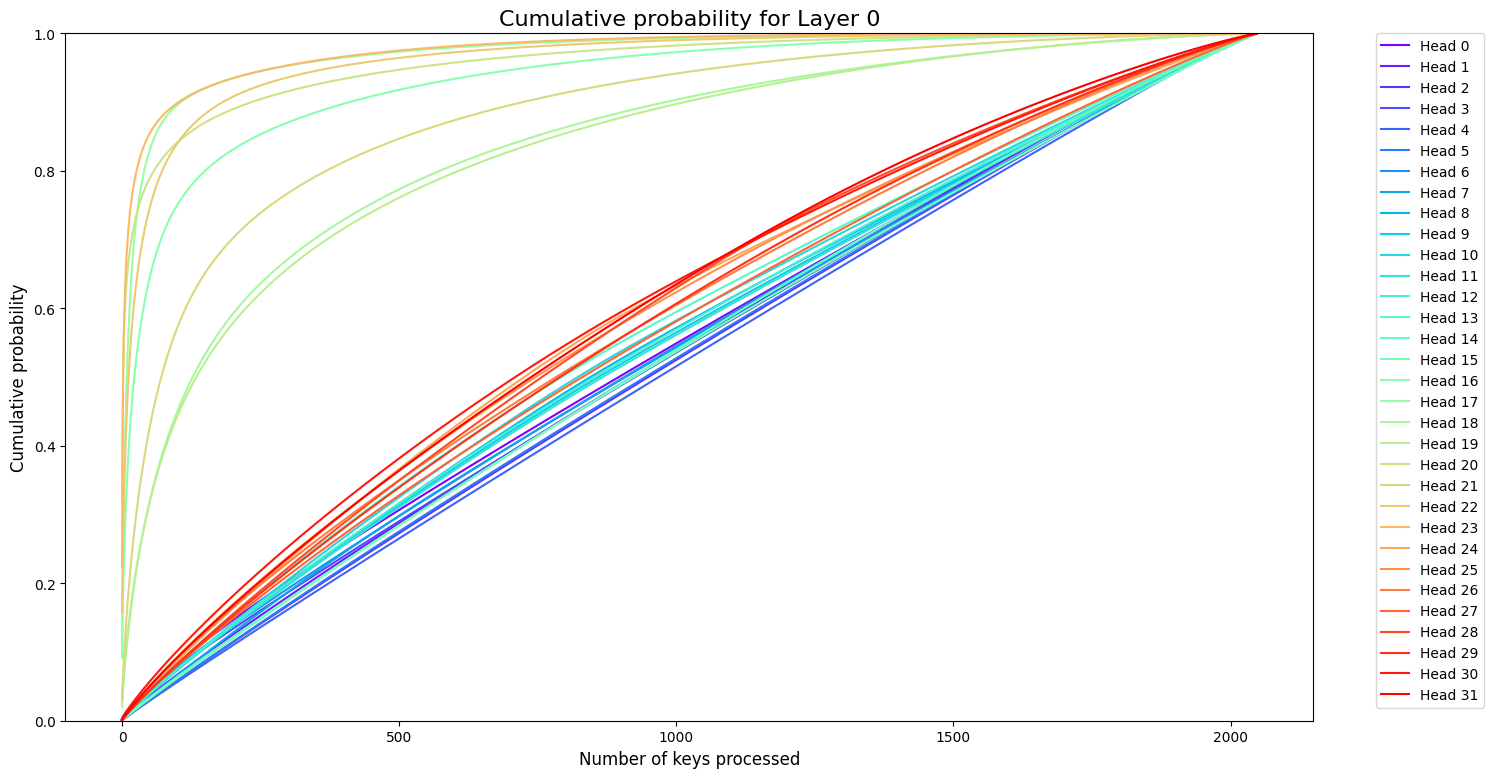

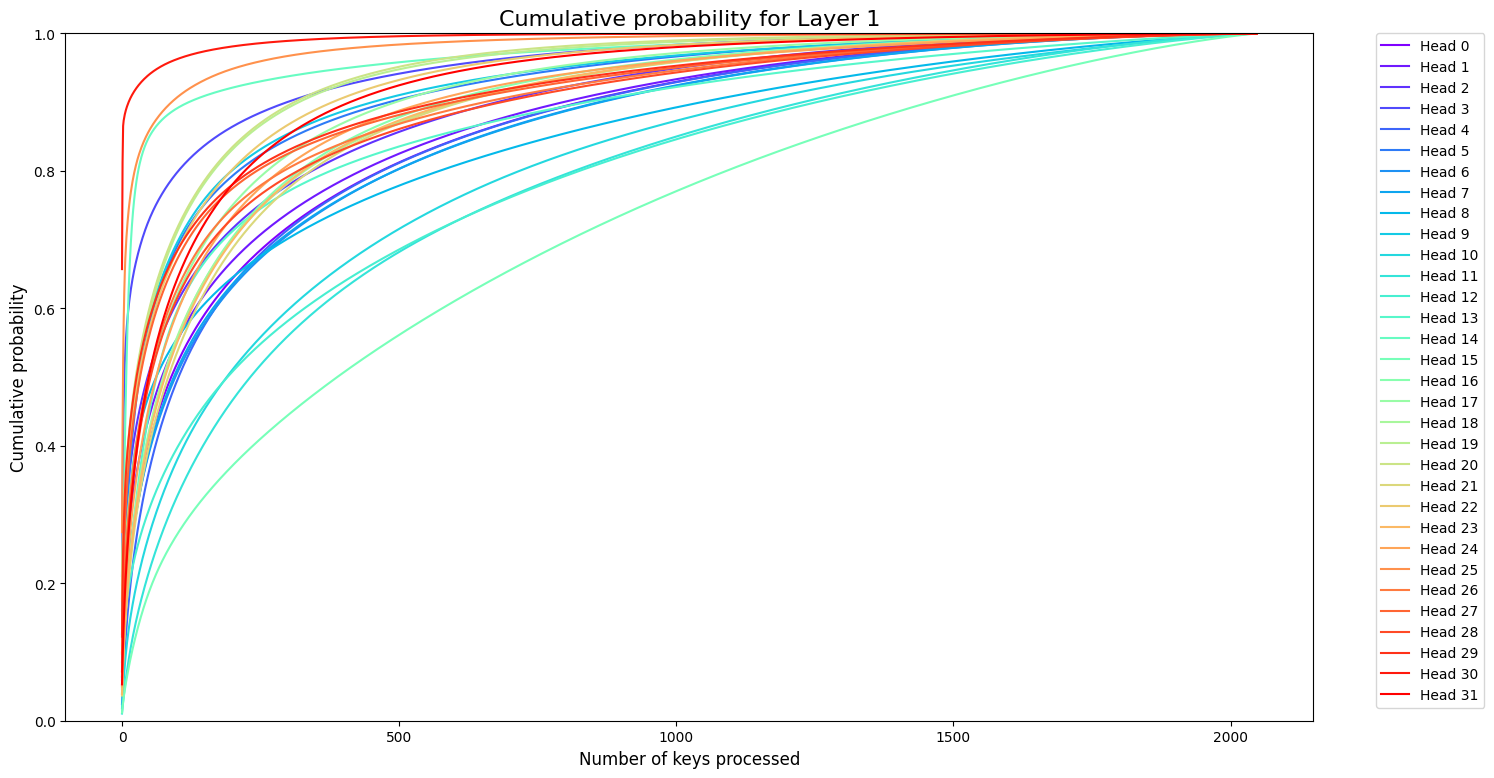

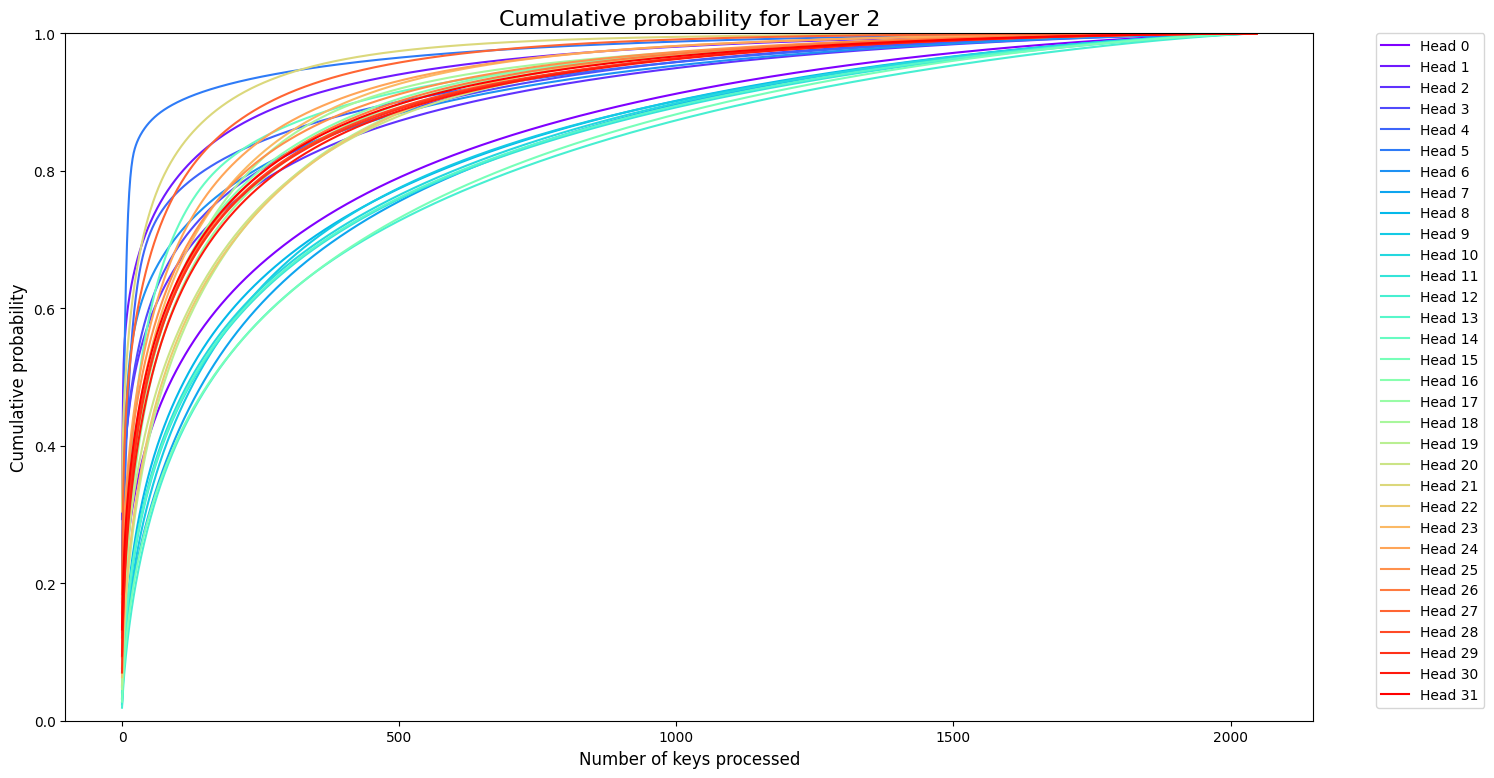

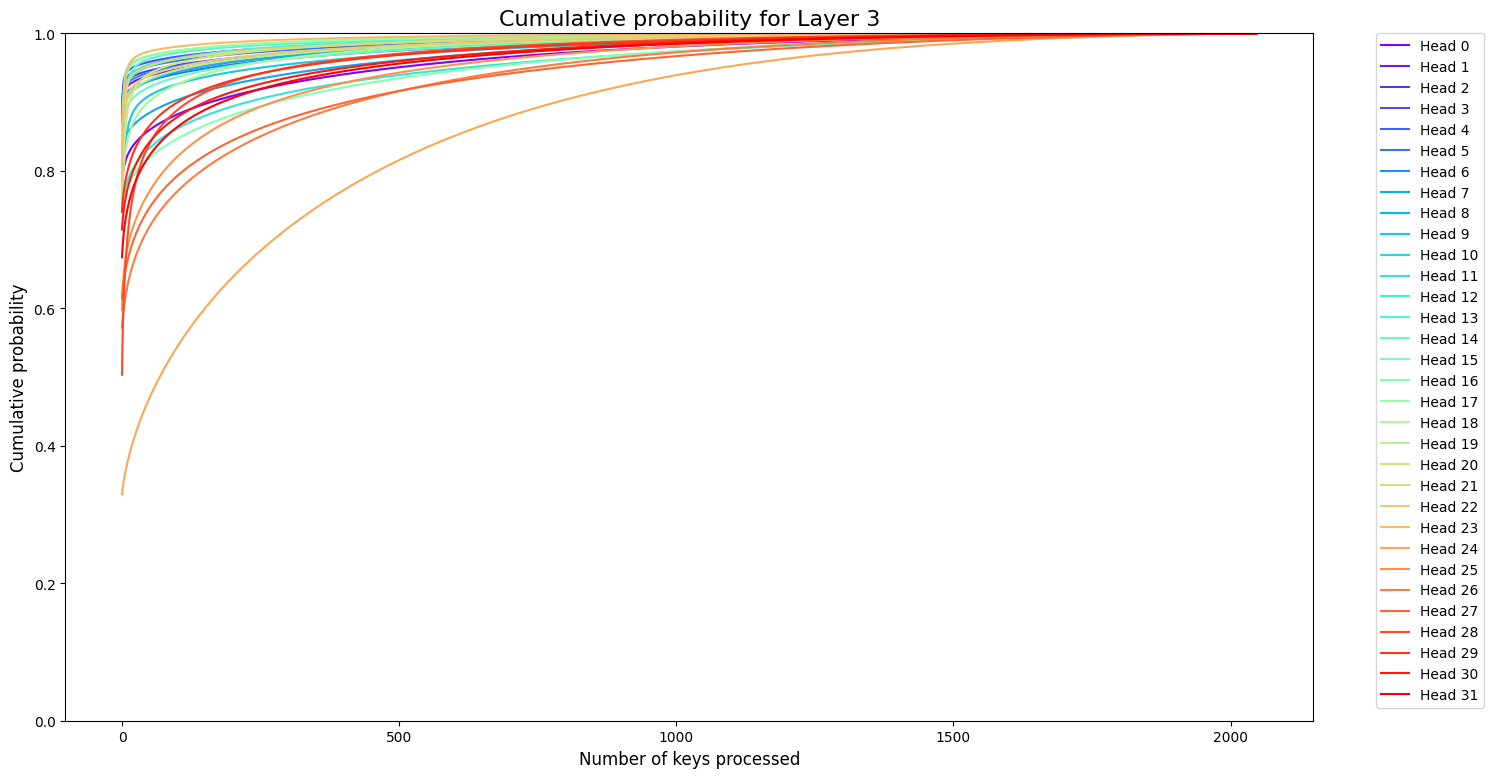

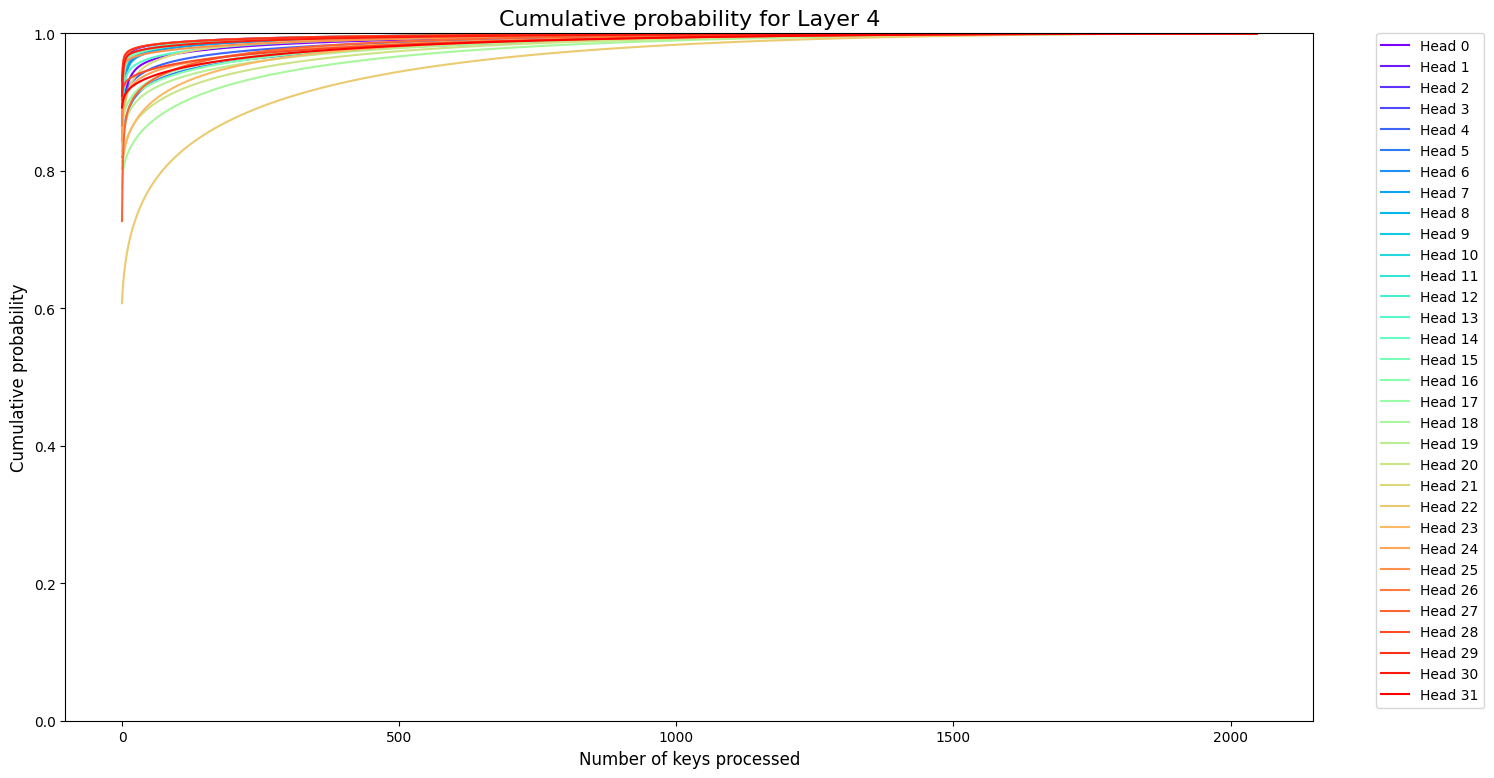

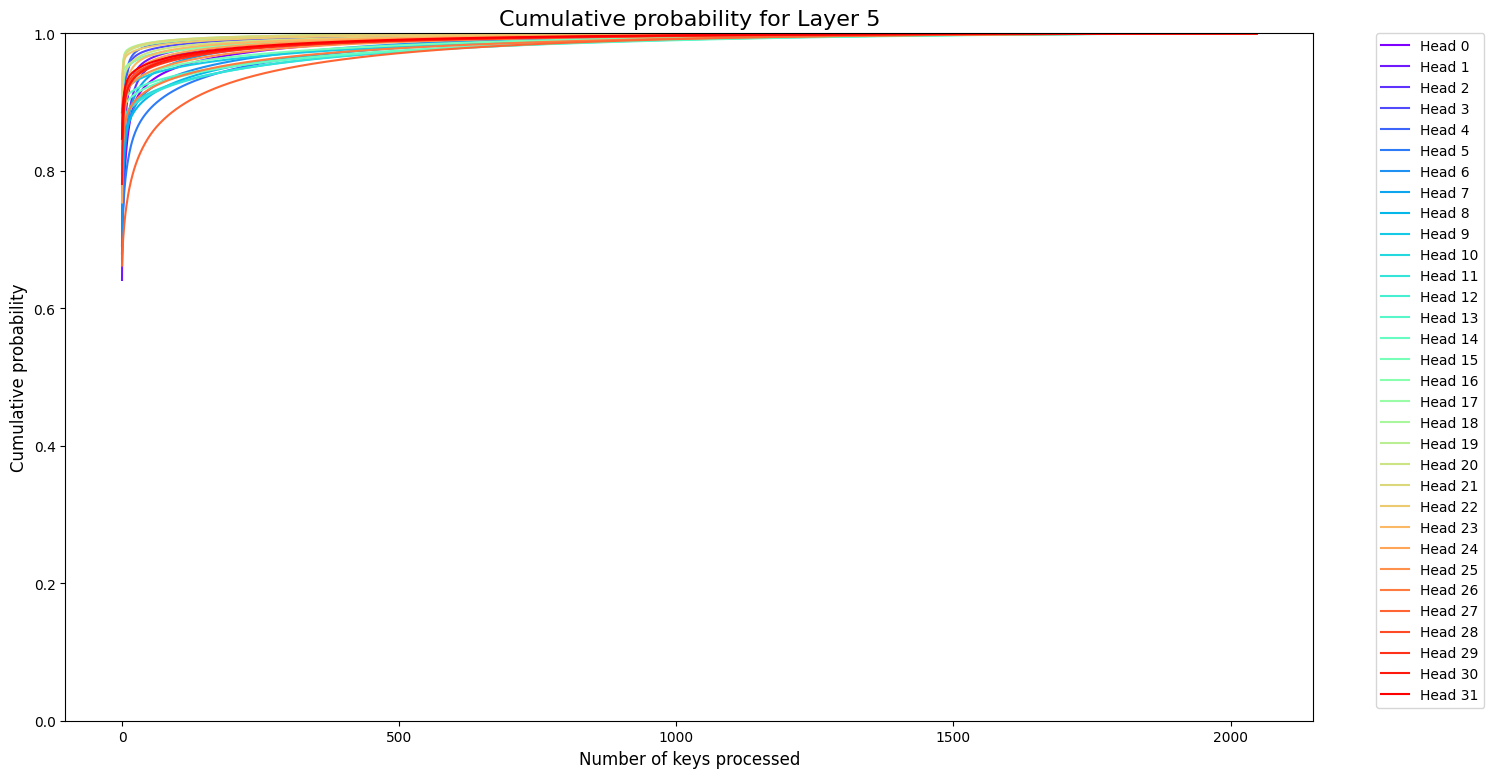

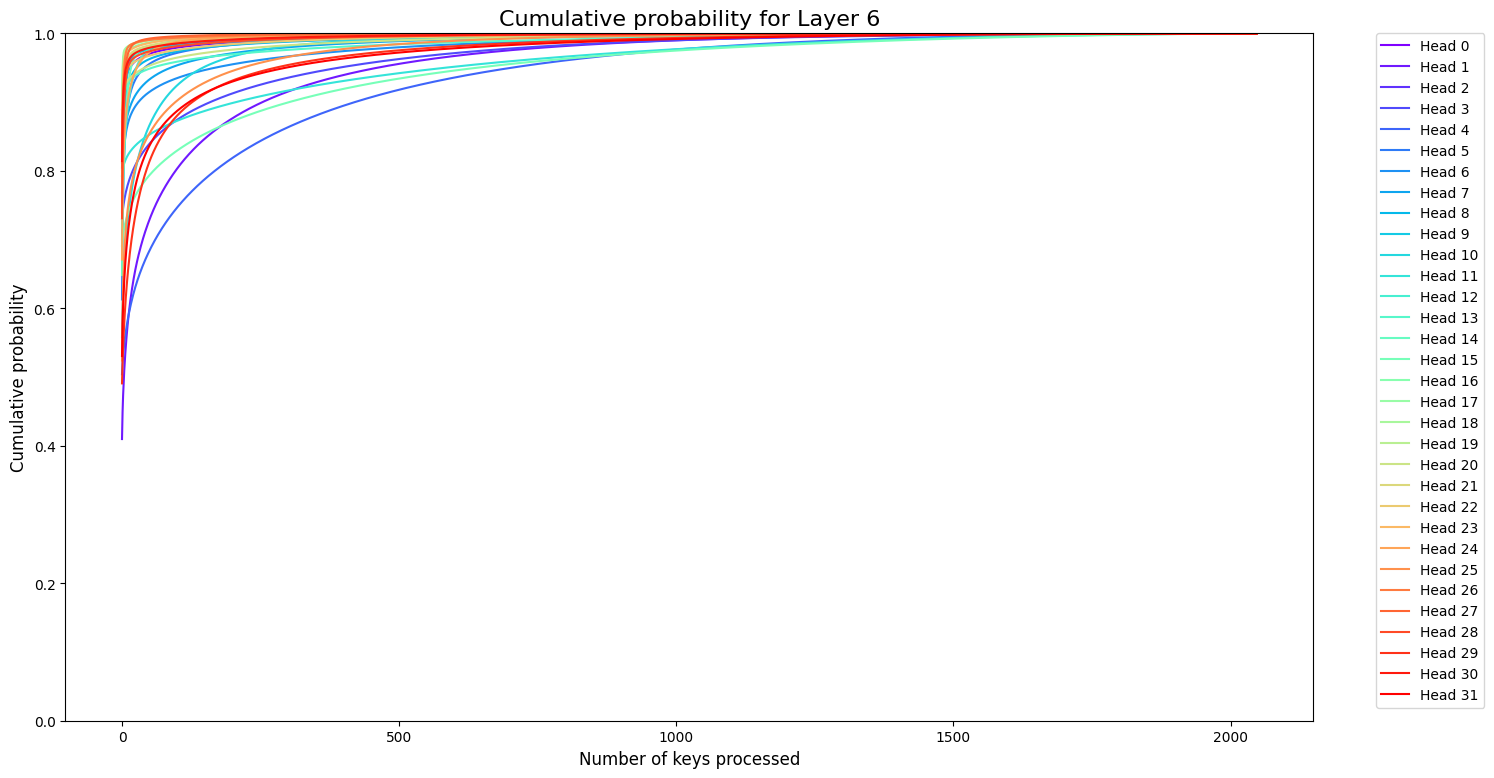

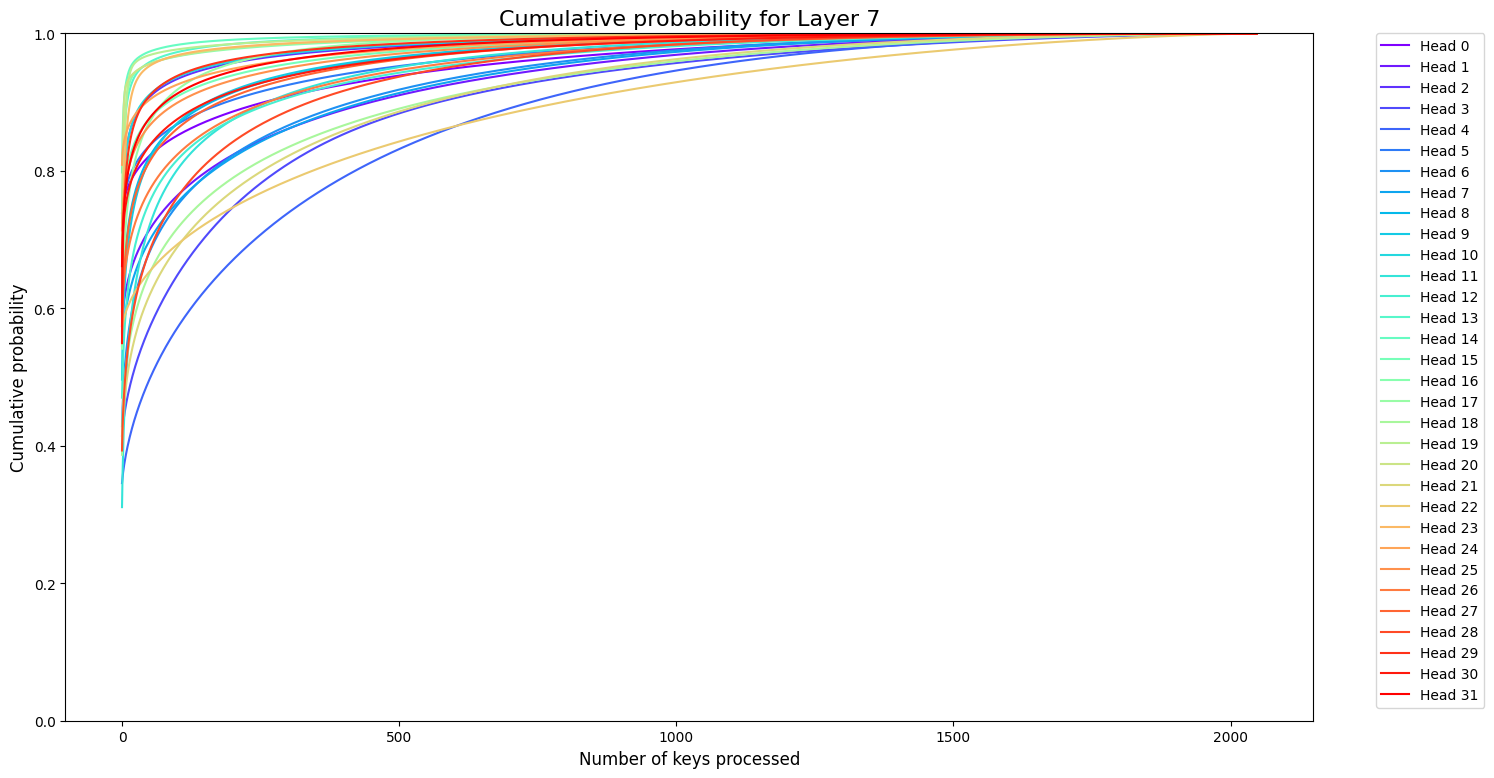

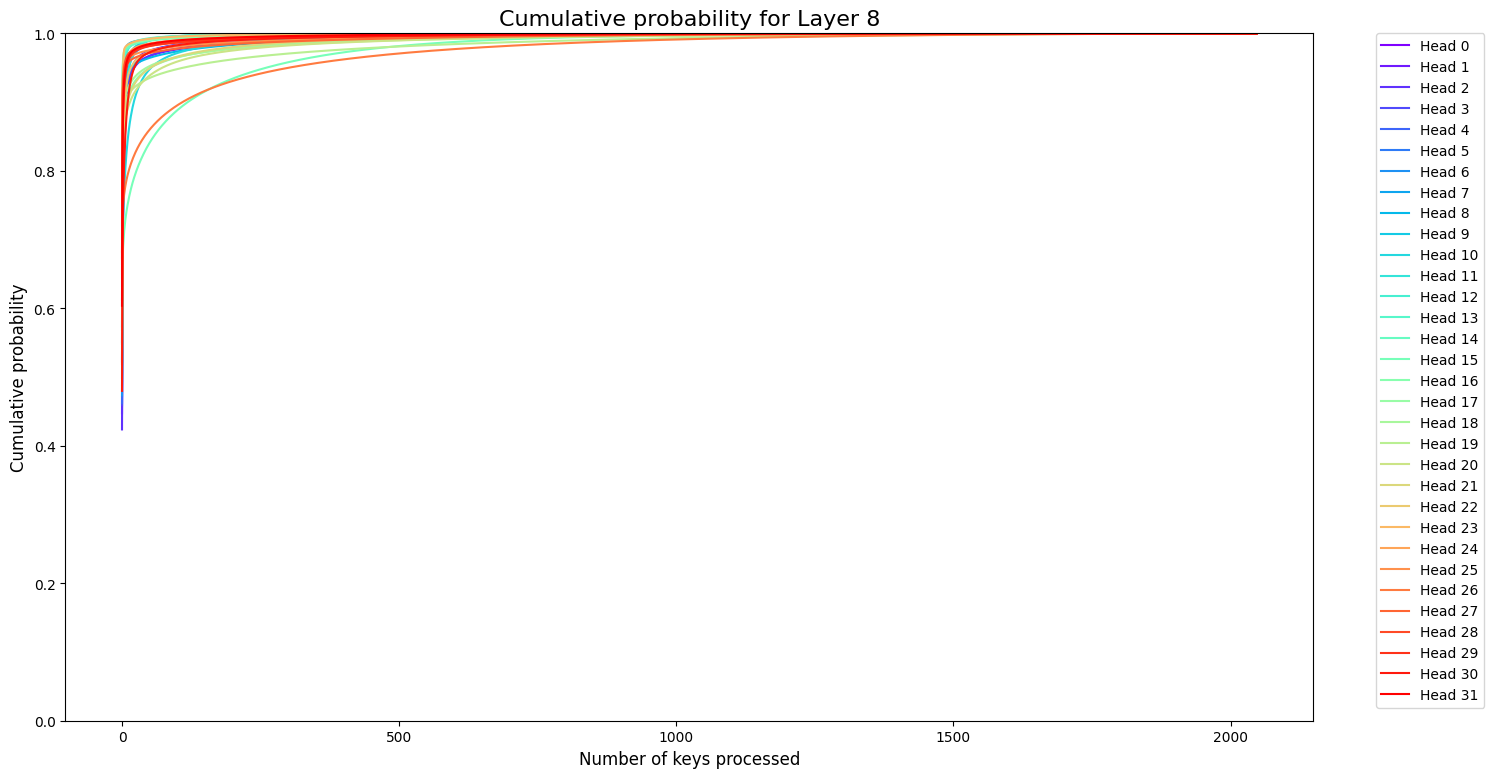

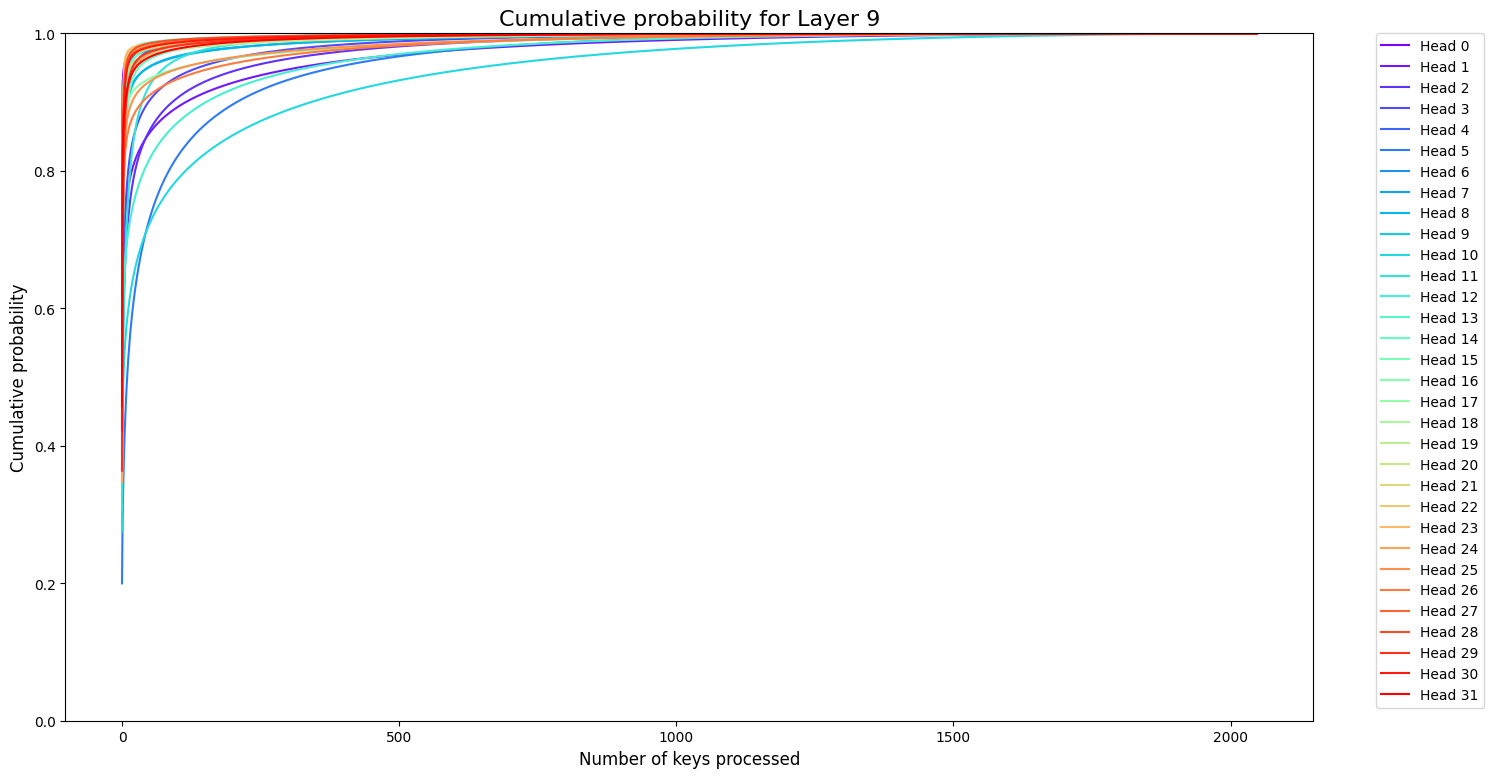

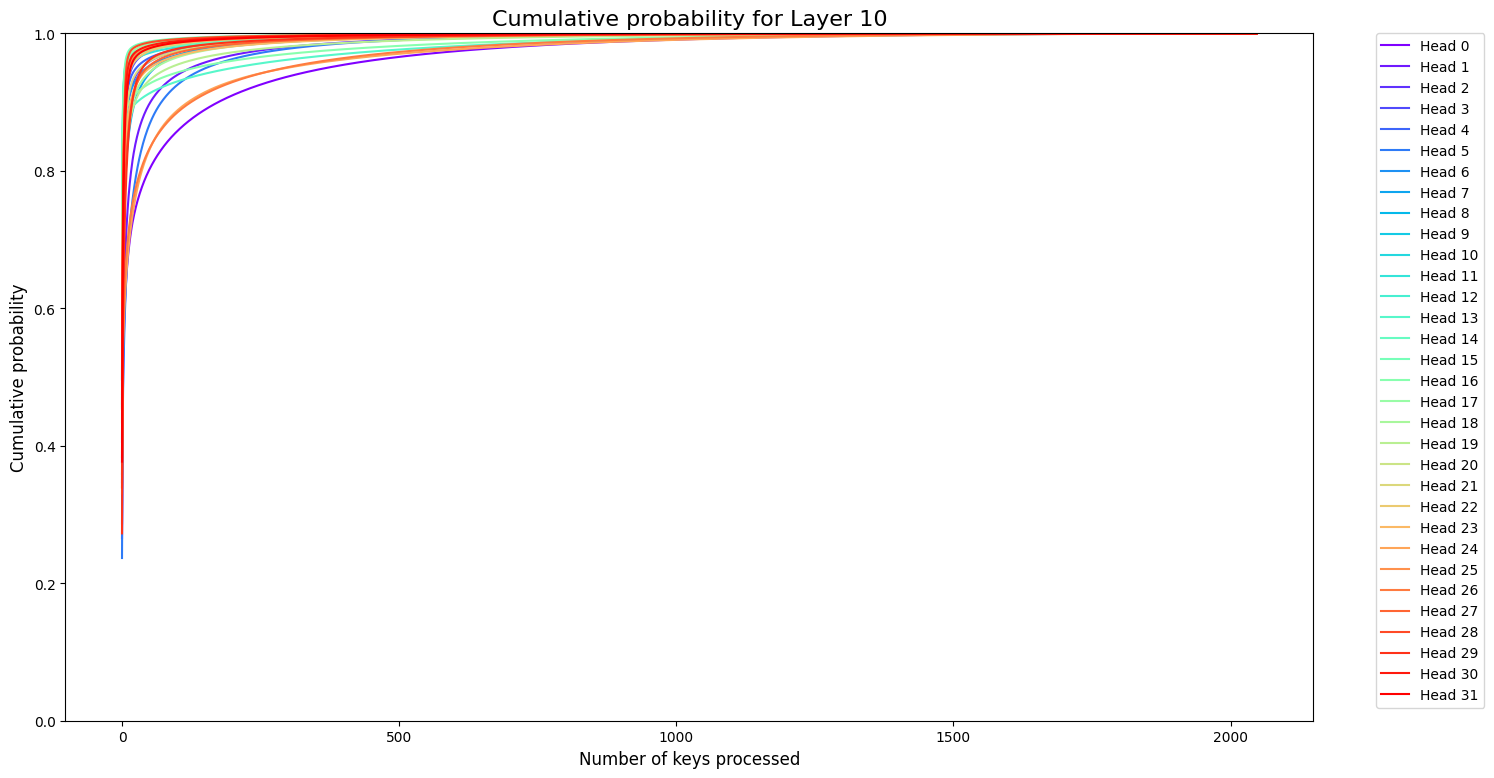

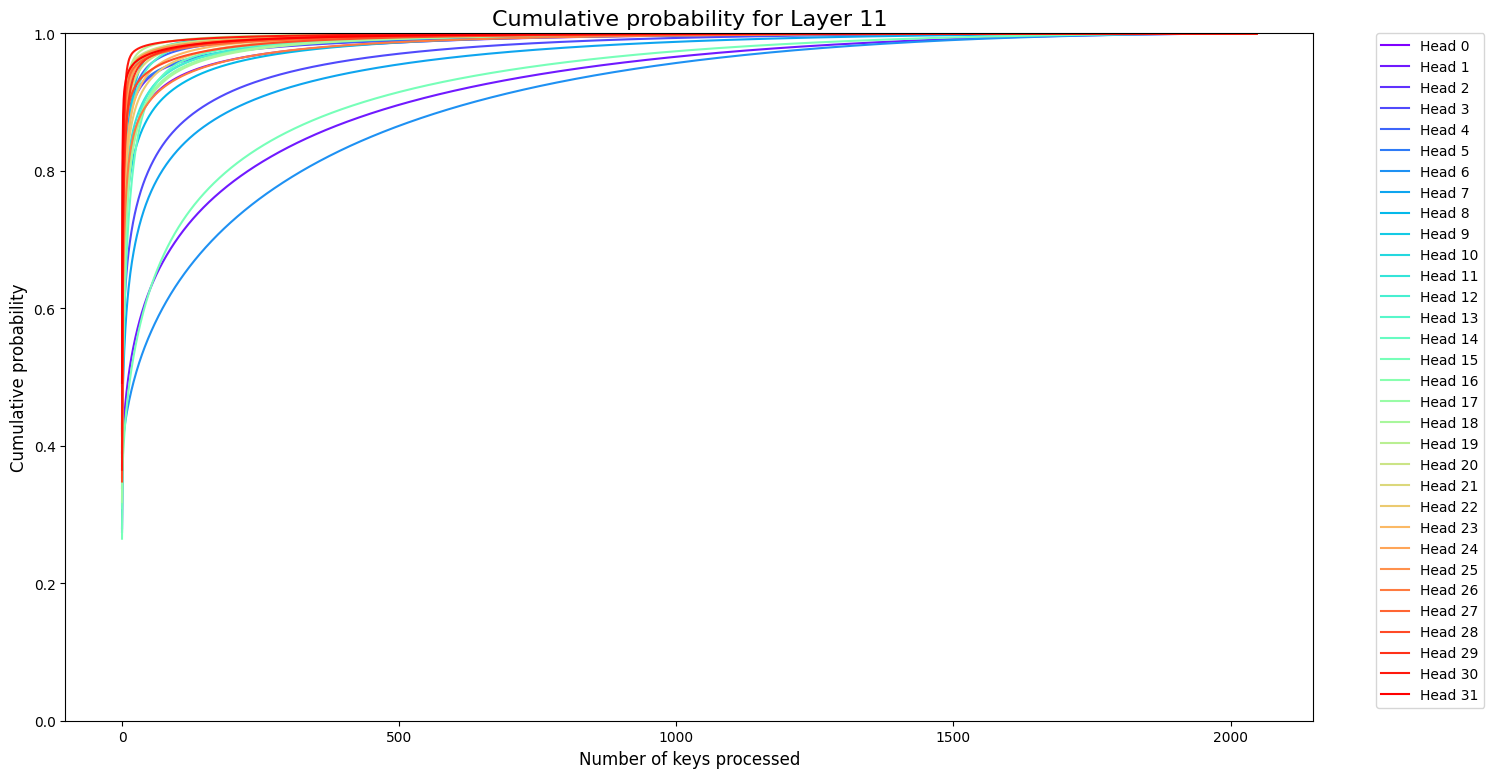

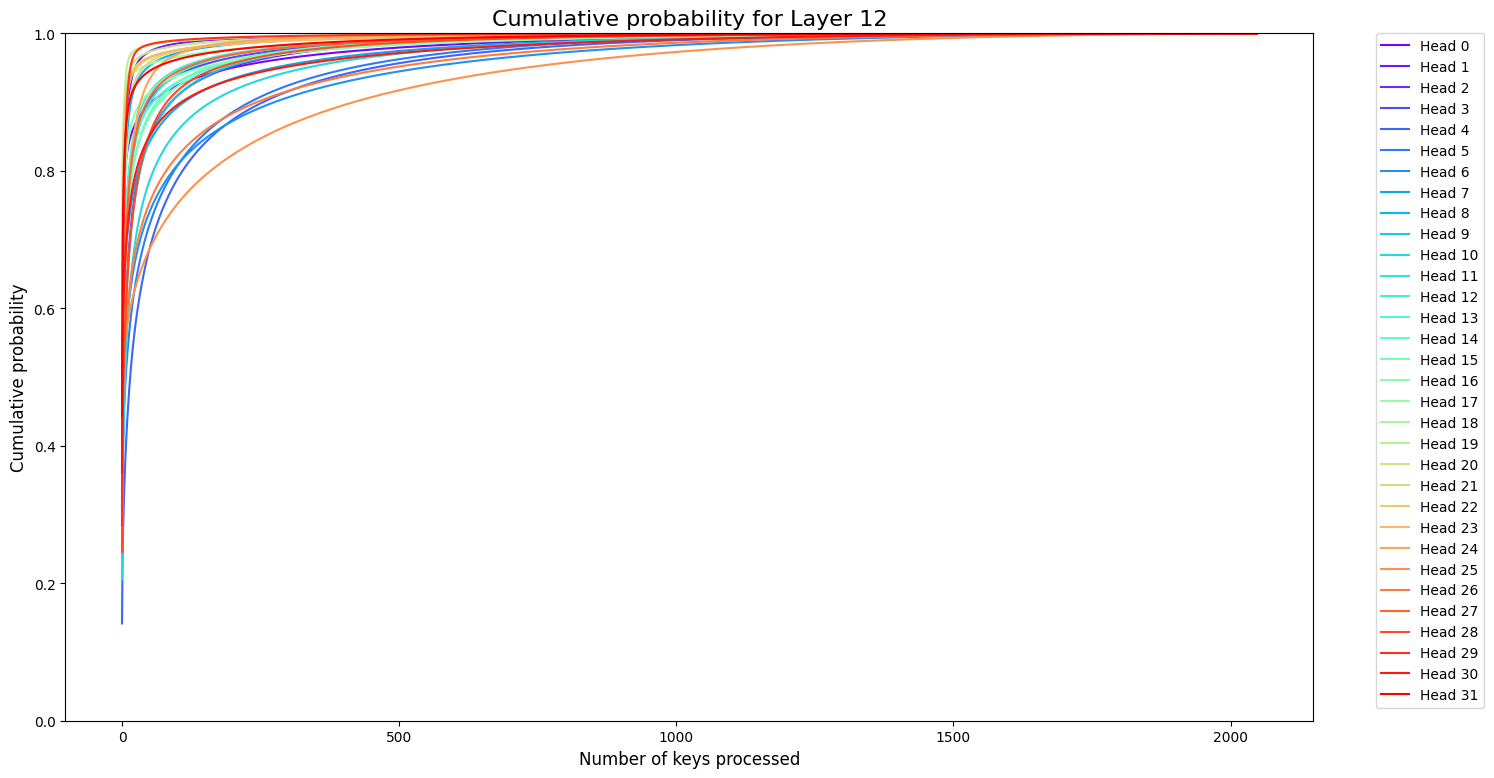

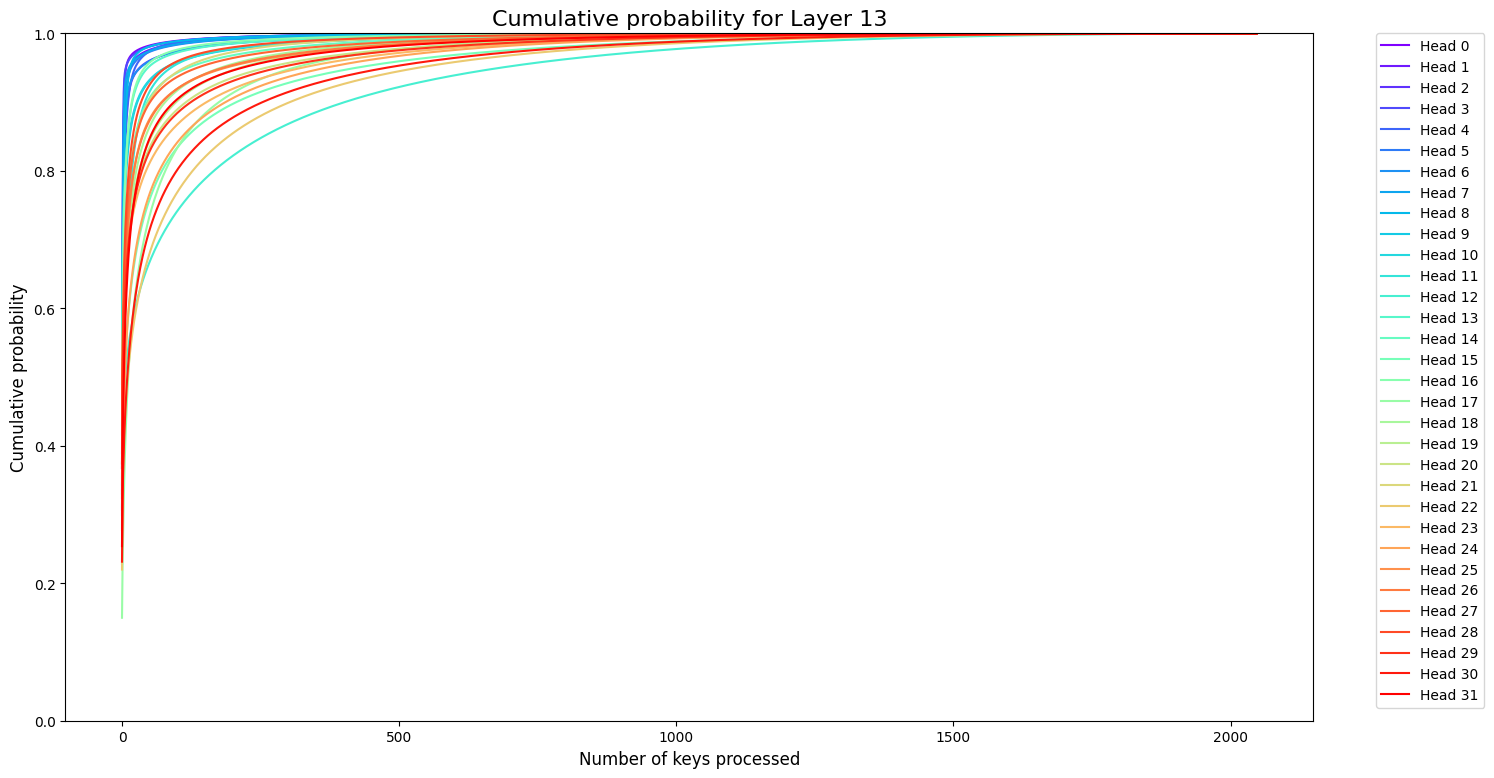

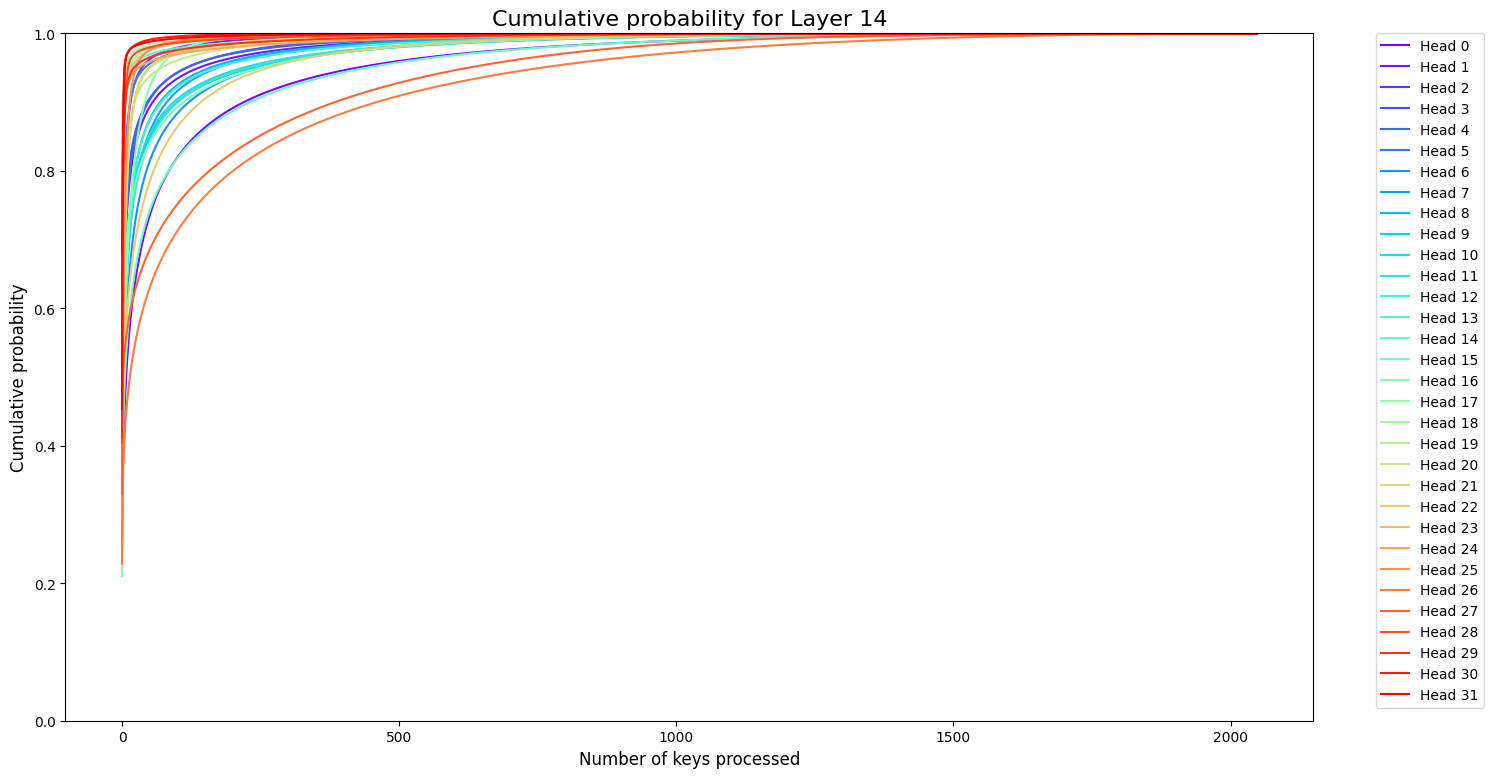

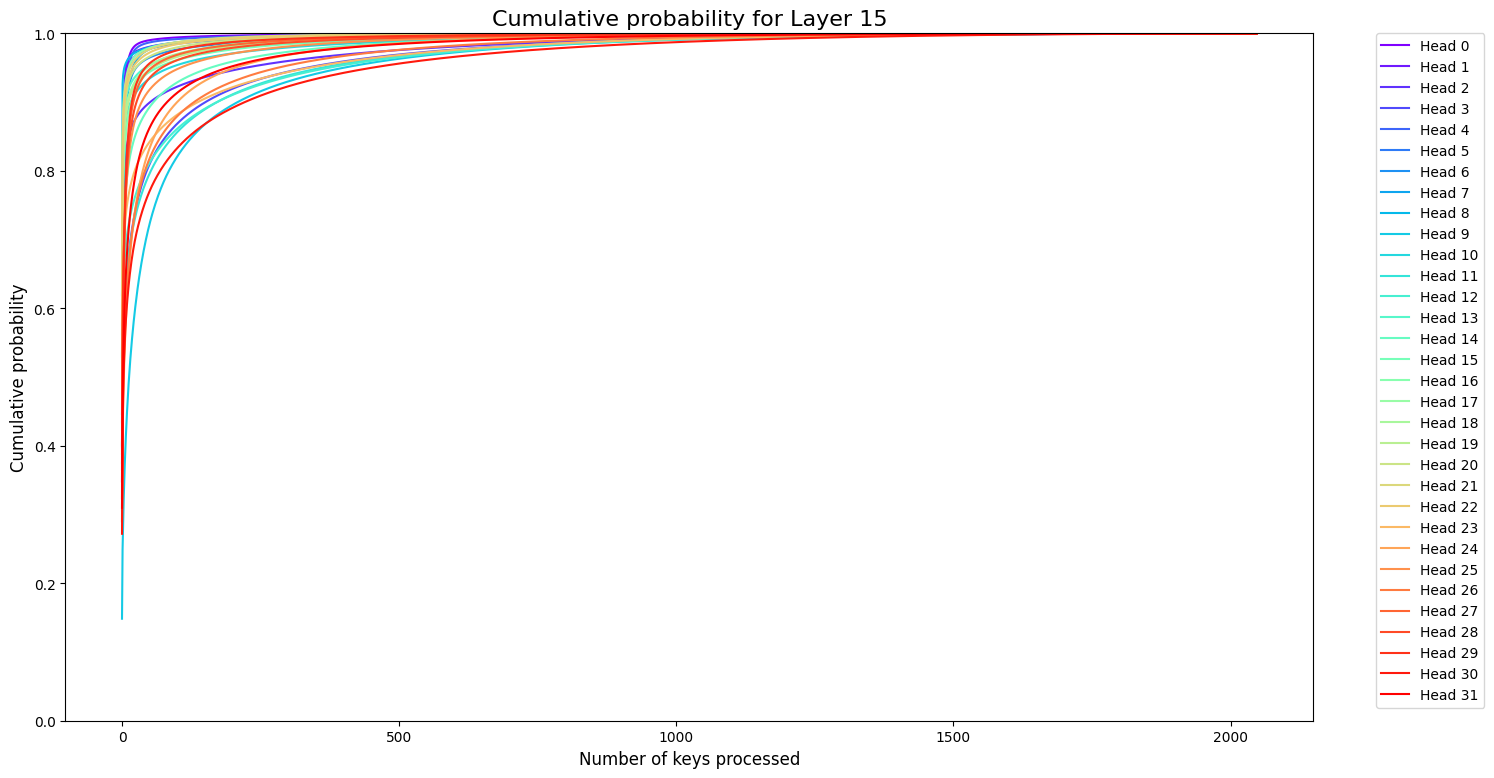

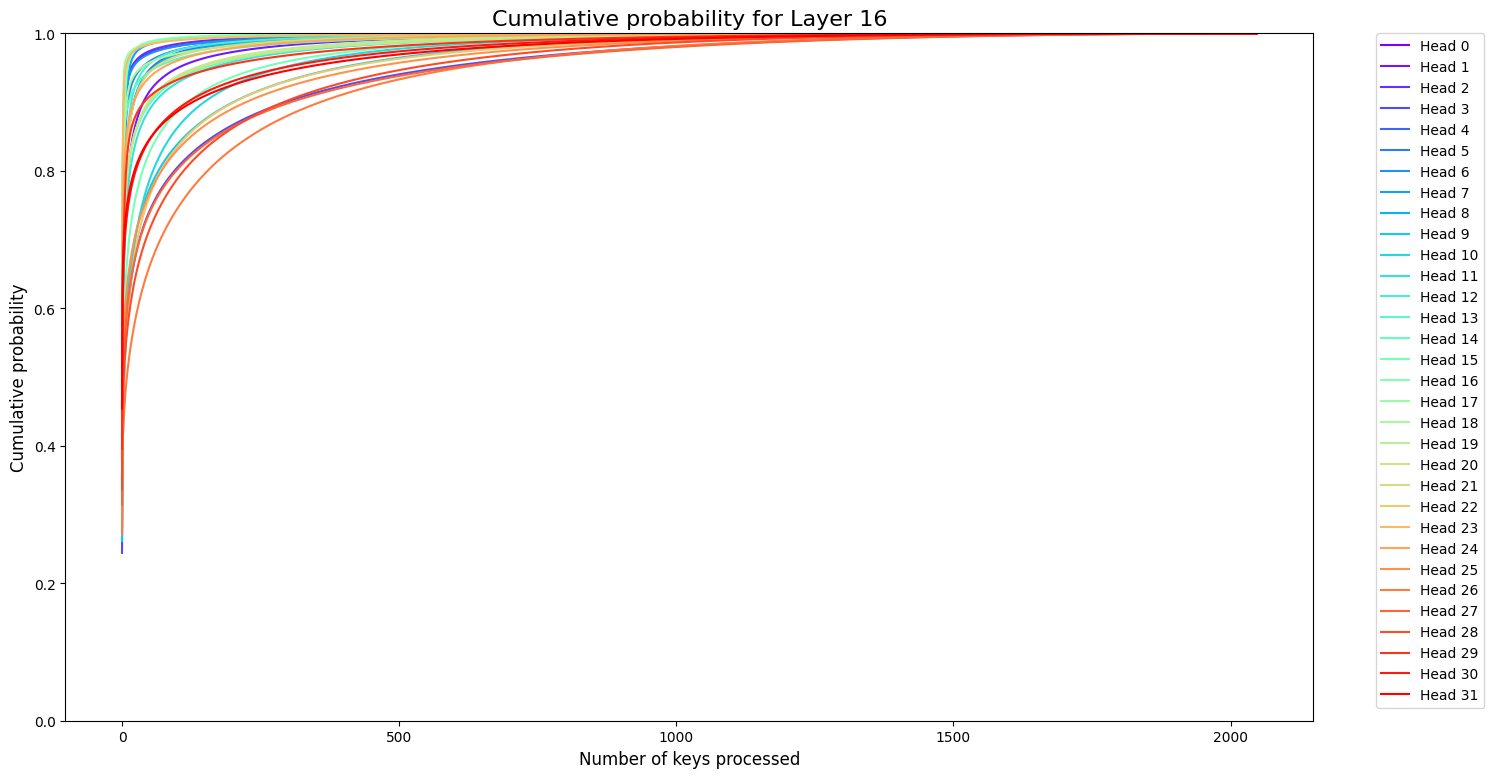

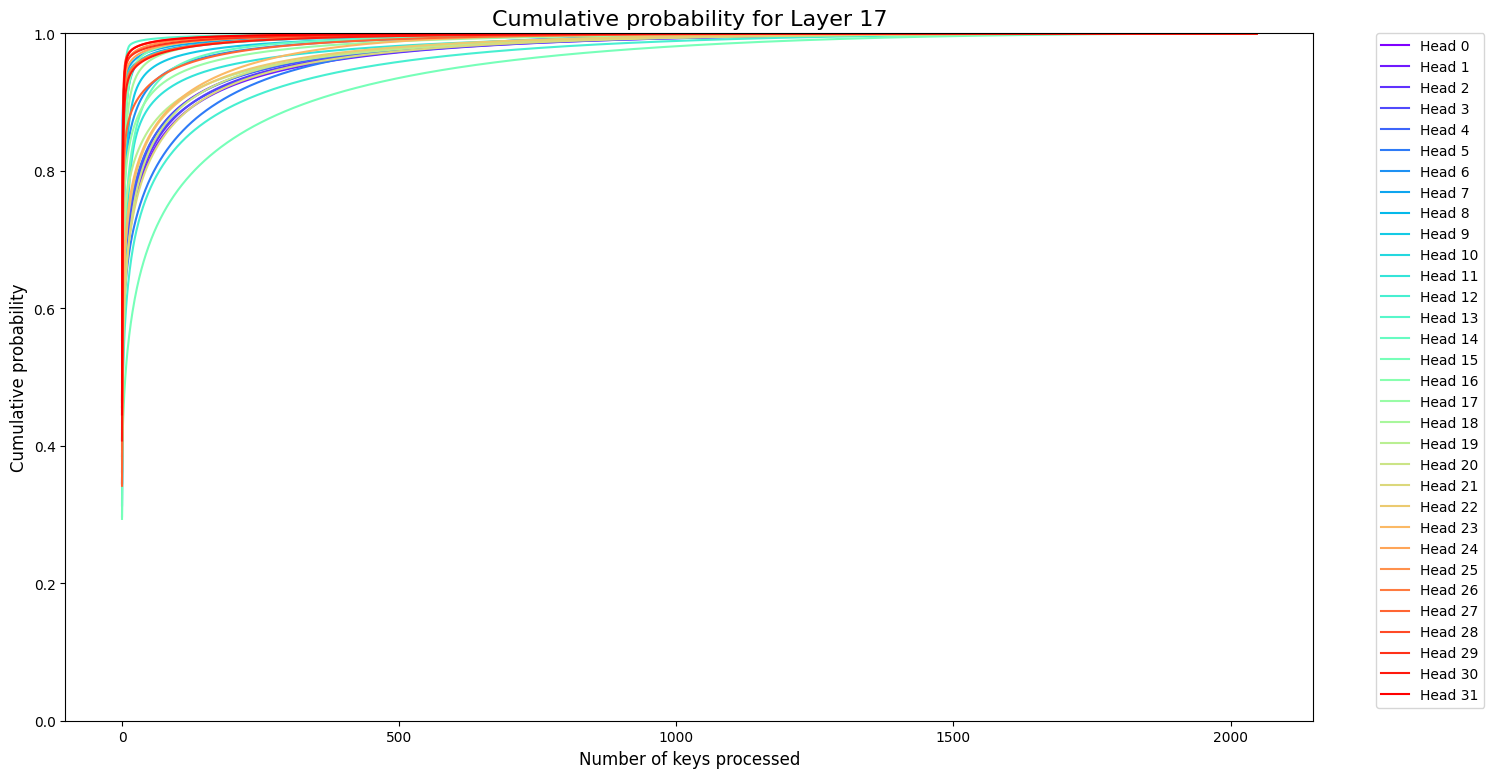

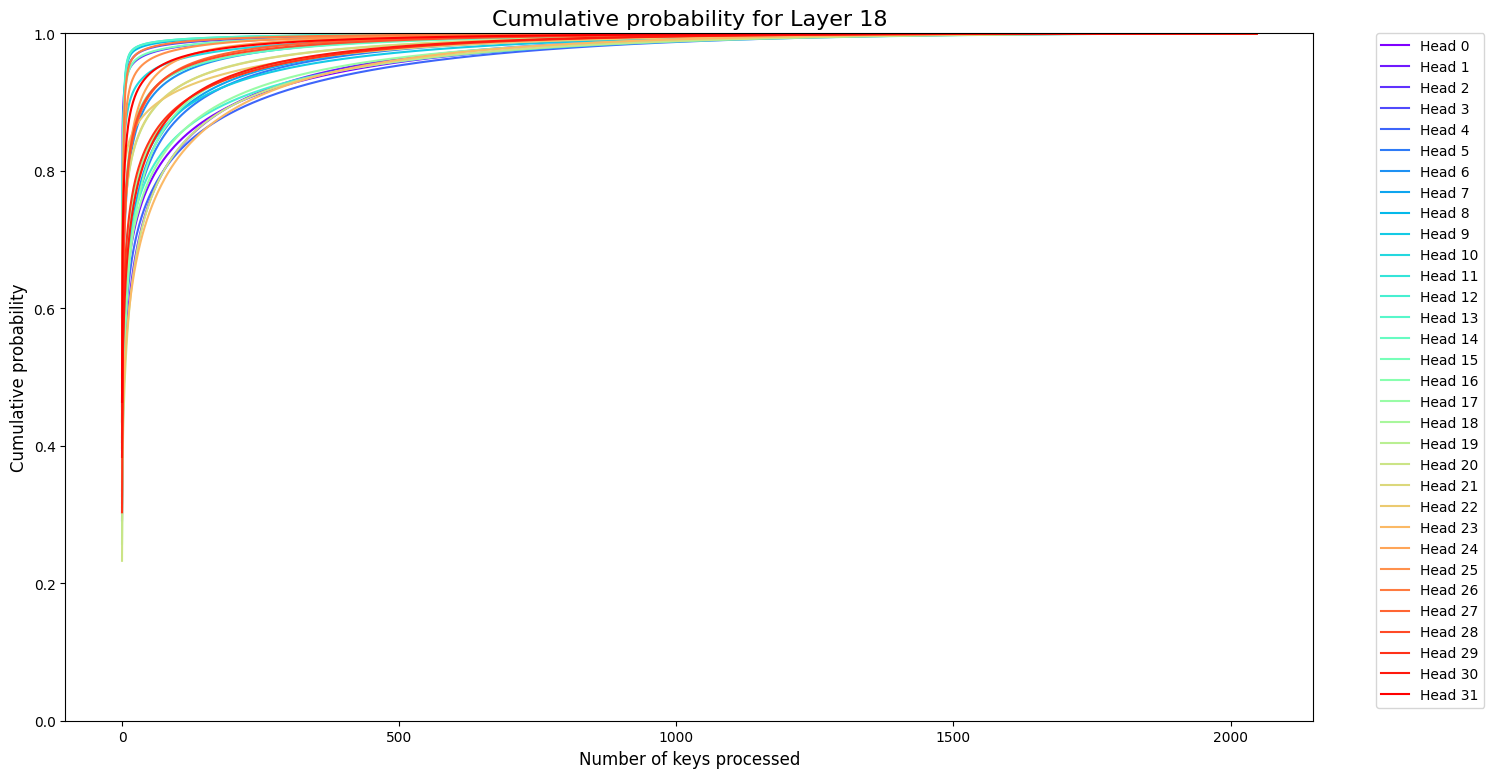

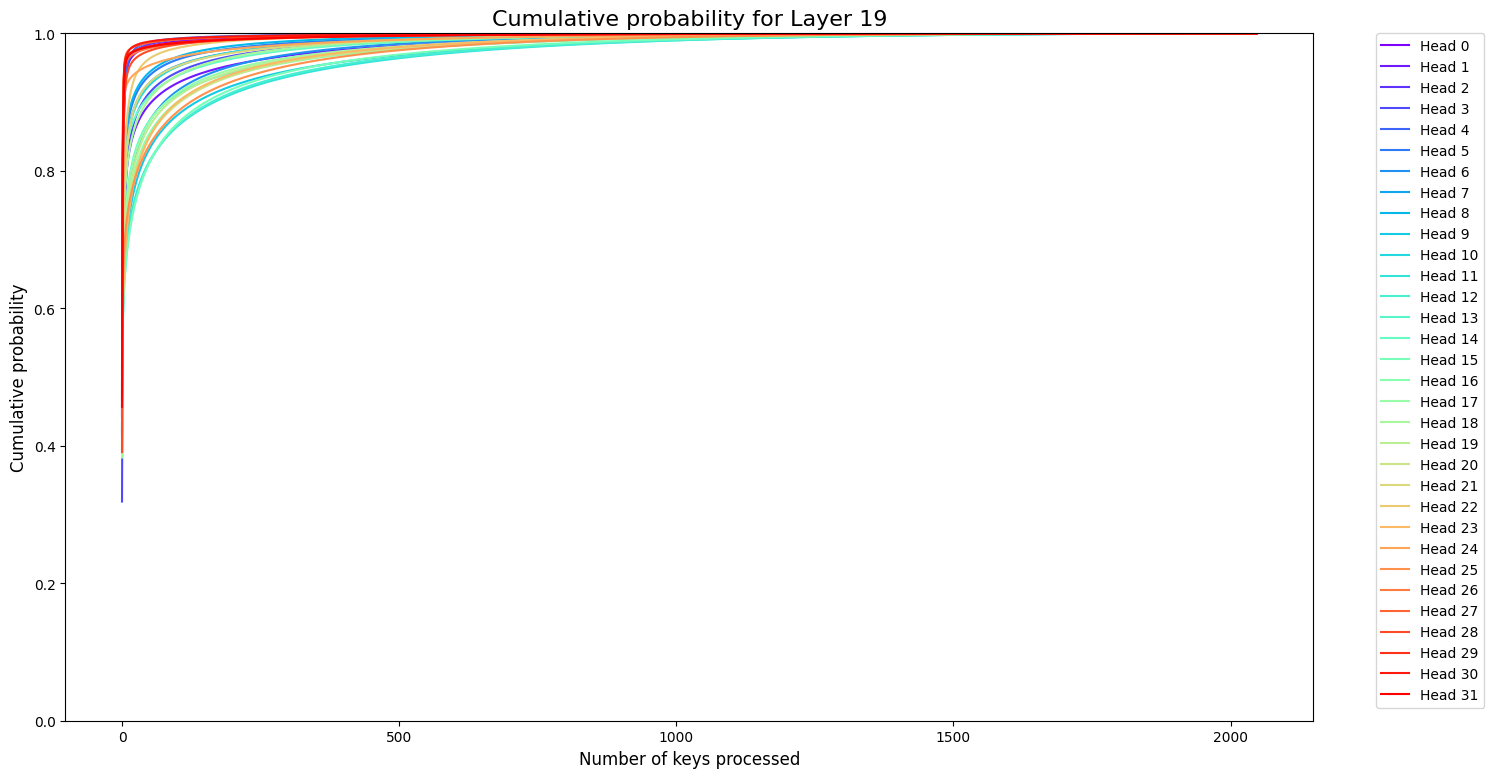

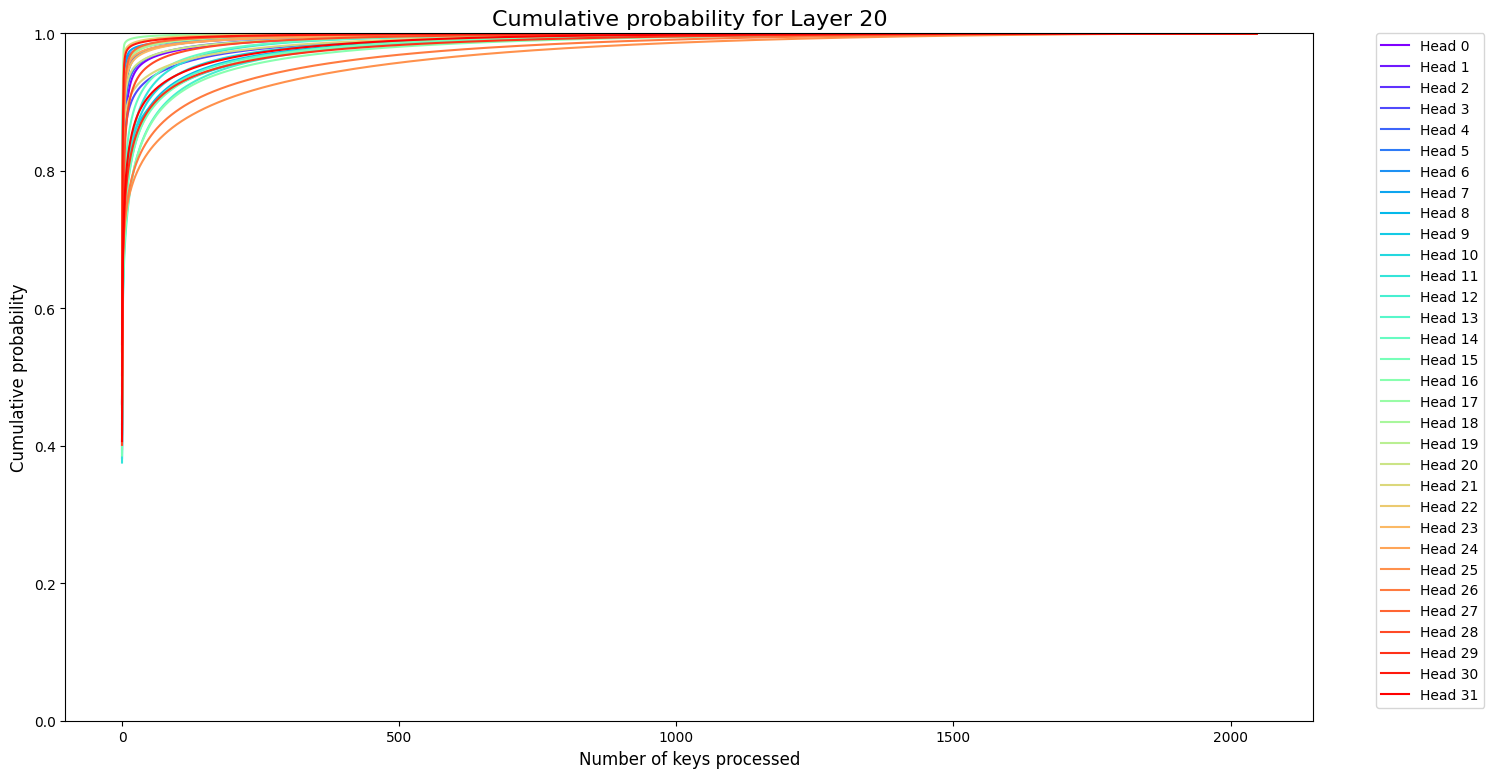

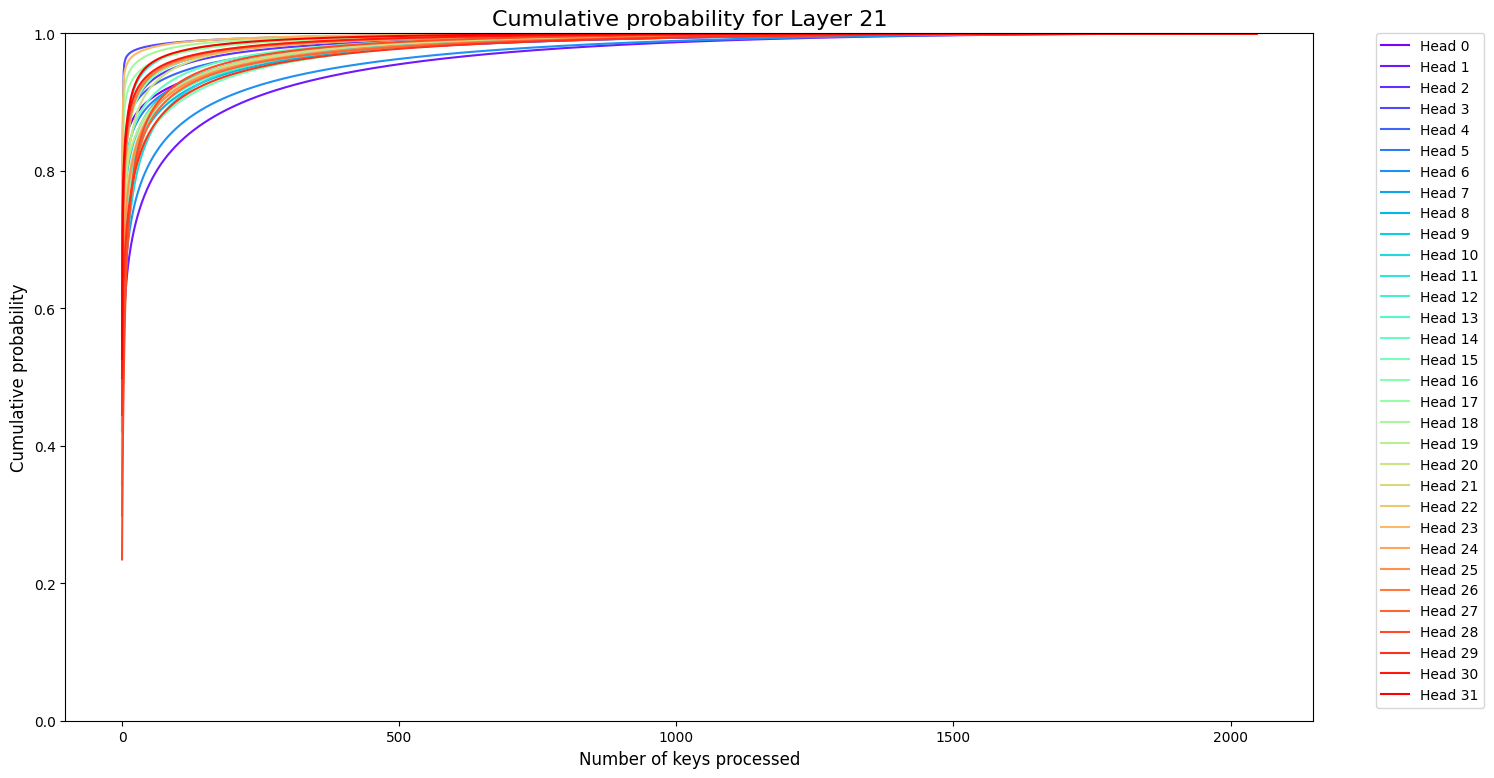

In [ ]:
# %%

plot_cum_prob_per_layer(cumsum_metrics["avg"].numpy())